In [1]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
"""
    accuracy_score used to calculate the accuracy of either the faction or count of correct prediction in Python Scikit learn.
    Compute the F1 score, also known as balanced F-score or F-measure.
    
    The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. 
    The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
    The best value is 1 and the worst value is 0.
    
    The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. 
    The recall is intuitively the ability of the classifier to find all the positive samples.
    The best value is 1 and the worst value is 0.
    
    The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches 
    its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal.
    
    This metric is calculated as:
    F1 Score = 2 * (Precision * Recall) / (Precision + Recall)
"""

import matplotlib.pyplot as plt
"""
    Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python. 
"""

from sklearn.metrics import classification_report, confusion_matrix
"""
    classification_report builds a text report showing the main classification metrics. 
    confusion_matrix computes confusion matrix to evaluate the accuracy of a classification.
"""

""" 
    Itertools is a module in python, it is used to iterate over data structures that can be stepped over using a 
    for-loop. Such data structures are also known as iterables.
"""
import itertools



In [2]:
import tensorflow as tf
"""
    It can be used across a range of tasks but has a particular focus
    on training and inference of deep neural networks.
"""
import tensorflow_hub as hub
"""
    TensorFlow Hub is a repository of trained machine learning models ready for
    fine-tuning and deployable anywhere. Reuse trained models like BERT and Faster 
    R-CNN with just a few lines of code.
"""

"""
    It is a TensorFlow library of text related ops, modules, and subgraphs. The library can
    perform the preprocessing regularly required by text-based models, and includes other
    features useful for sequence modeling not provided by core TensorFlow.
"""
import tensorflow_text as text

In [3]:
import pandas as pd
"""
    Used for data manipulation and analysis
"""
df=pd.read_excel('../data/Constraint_Train.xlsx')
"""
    Read an Excel file into a pandas DataFrame
"""

"""
    Prints top 5 rows of excel file
"""
df.head(5)

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [4]:
"""
    Here we are storing the tweets with fake label in df_fake, and printing its shape.
"""
df_fake = df[df['label']=='fake']
df_fake.shape

(3060, 3)

In [5]:
"""
    Here we are storing the tweets with real label in df_real, and printing its shape.
"""
df_real = df[df['label']=='real']
df_real.shape

(3360, 3)

In [6]:
"""
    Here we are extracting randomly downsampled from real sample.
"""
df_real_downsampled = df_real.sample(df_fake.shape[0])
df_real_downsampled.shape

(3060, 3)

In [7]:
"""
    Here we are concatinating df_real_downsampled and df_fake.
"""
df_balanced = pd.concat([df_real_downsampled, df_fake])
df_balanced.shape

(6120, 3)

In [8]:
"""
    Printing Number of tweets having fake and real label
"""
df_balanced['label'].value_counts()

fake    3060
real    3060
Name: label, dtype: int64

In [9]:
"""
    We are transforming the labels from 'fake' to 0 and 'real' to 1.
"""
df_balanced['fake']=df_balanced['label'].apply(lambda x: 1 if x=='fake' else 0)
df_balanced.sample(5)

,id,tweet,label,fake
4636,4637,#HCPs: COCA Call on Wed March 25 at 2pm ET can...,real,0
3535,3536,The COVAX Facility will help to: -bring the #C...,real,0
5180,5181,Demanding a fair Probe #JusticforTarun.(1)..Wh...,fake,1
3936,3937,#IndiaFightsCorona: There is exponential incre...,real,0
1936,1937,Bill Gates will make $200 billion through vacc...,fake,1


In [10]:
from sklearn.model_selection import train_test_split
"""
    Here we are spliting the dataset, where the test_size is 1/3 of all data.
"""
X_train, X_test, y_train, y_test = train_test_split(df_balanced['tweet'],df_balanced['fake'], stratify=df_balanced['fake'])

In [11]:
"""
    Here we are importing the BERT model and embedding vectors.
"""
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1")

In [12]:
# Bert layers
"""
    Here we are adding the different layers of BERT.
"""
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
"""
    Adding different parameters and properties to our model.
"""
l = tf.keras.layers.Dense(128,activation='relu', name="output")
#l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])(l)
l = tf.keras.layers.Dense(64, activation='relu', name="output")
l = tf.keras.layers.Dense(32, activation='relu', name="output")
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)



# Use inputs and outputs to construct a final model
"""
    Intializing the model.
"""
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [13]:
"""
    Printing the model summary.
"""
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [14]:
"""
    Printing the number of rows in X_train
"""
len(X_train)

4590

In [15]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]
"""
    Initializing the Metrics to later print the accuracy, precision and recall.
"""
"""
    Binary cross entropy compares each of the predicted probabilities to 
    actual class output which can be either 0 or 1, and use it as a loss funtion.
    
    Adam optimizer involves a combination of two gradient descent methodologies: 
        - Momentum.
        - Root Mean Square Propagation (RMSP). 
"""
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [16]:
#Training the model
""" 
    Here we are training the model where epochs is the number of times we iterate over the training set 
    and the number of training examples utilized in one iteration.
"""
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
72/72 [==============================] - 144s 2s/step - loss: 0.5450 - accuracy: 0.7390 - precision: 0.7687 - recall: 0.6837 - val_loss: 0.4367 - val_accuracy: 0.8190 - val_precision: 0.8813 - val_recall: 0.7373
Epoch 2/10
72/72 [==============================] - 128s 2s/step - loss: 0.4109 - accuracy: 0.8255 - precision: 0.8623 - recall: 0.7747 - val_loss: 0.3755 - val_accuracy: 0.8392 - val_precision: 0.8788 - val_recall: 0.7869
Epoch 3/10
72/72 [==============================] - 129s 2s/step - loss: 0.3716 - accuracy: 0.8392 - precision: 0.8759 - recall: 0.7904 - val_loss: 0.3477 - val_accuracy: 0.8477 - val_precision: 0.8900 - val_recall: 0.7935
Epoch 4/10
72/72 [==============================] - 128s 2s/step - loss: 0.3440 - accuracy: 0.8508 - precision: 0.8808 - recall: 0.8113 - val_loss: 0.3309 - val_accuracy: 0.8575 - val_precision: 0.8721 - val_recall: 0.8379
Epoch 5/10
72/72 [==============================] - 135s 2s/step - loss: 0.3299 - accuracy: 0.8582 - precisi

In [17]:
y_predicted = model.predict(X_test)
"""
    The model is fitted with trained data, and then used to make prediction.
"""

"""
    We are transforming the 2D array to a 1D array.
"""
y_predicted = y_predicted.flatten()

In [18]:
import numpy as np
"""
    NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays 
    and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.
"""
y_predicted = np.where(y_predicted > 0.5, 1, 0)
"""
    Here we are converting all the probable values between 0 and 1, to 0 or 1.
"""
y_predicted

array([1, 1, 0, ..., 1, 1, 1])

In [19]:
def create_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    to plot a sklearn confusion matrix(cm)

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    """
        Accuracy (all correct / all) = (TP + TN) / (TP + TN + FP + FN)
    """
    
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('YlOrRd') 
    """ 
        To select the colour theme of the confusion matrix
    """

    plt.figure(figsize=(5, 4))
    """
        To create a figure with the given width, height in inches.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    """
       To display data as an image, i.e., on a 2D regular raster.
    """
    
    plt.title(title)
    plt.colorbar()
    """
       To display a title and colorbar on the axes.
    """
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        
    """
        To put the labels on the confusion matrix, with or without rotation.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    """
        To normalize the confusion matrix by slicing and adding a new axis.
    """


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    """
        To calculate the threshold by finding the maximum value in confusion matrix.
    """
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    """
        To display the values in the confusion matrix with different colours and precision.
    """

    plt.tight_layout()
    """
        This automatically adjusts subplot params so that the subplot(s) fits in to the figure area. 
    """
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    """
        To plot the the labels on their respective axes.
    """
    
    plt.show()
    """
        To show the confusion matix on screen.
    """

In [20]:
def print_metrices(y_predicted,y_test):
    print(confusion_matrix(y_test,y_predicted))
    print(classification_report(y_test,y_predicted,))
    print("Accuracy : ",accuracy_score(y_predicted,y_test))
    print("Precison : ",precision_score(y_predicted,y_test, average = 'weighted'))
    print("Recall : ",recall_score(y_predicted,y_test,  average = 'weighted'))
    print("F1 : ",f1_score(y_predicted,y_test,  average = 'weighted'))
    """
        Here, we are printing the confusion matrix, its accuracy, precision, recall and F1 score.
    """

BERT
val:
[[667  98]
 [ 88 677]]
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       765
           1       0.87      0.88      0.88       765

    accuracy                           0.88      1530
   macro avg       0.88      0.88      0.88      1530
weighted avg       0.88      0.88      0.88      1530

Accuracy :  0.8784313725490196
Precison :  0.8785168097740185
Recall :  0.8784313725490196
F1 :  0.8784365660139655


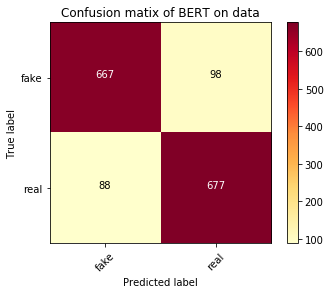

In [21]:
print('BERT')
print ('val:')
print_metrices(y_predicted,y_test)
"""
    Transform the data from the excel sheet which are not under 'label' 
    column and apply predict with the final estimator.

    This will be used later to print additional informations, like data types and memory used.
"""
create_confusion_matrix(confusion_matrix(y_test,y_predicted),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of BERT on data')